# **Info GPU:**
> Device 0: NVIDIA A100-SXM4-80GB

> Maximum threads per block: 1024

> Maximum blocks per grid: 2147483647

# **Setting Programma:**

> threads 512 --input data/100000x5.csv --output outputCuda/output100000x5.csv --seed 1953139 --k 20 --repetitions 40;

Keuze van threads: We hebben verschillen waarden uitgetest voor het aantal threads per block, resultaten kunt u hieronder vinden. 512 lijkt het snelste te zijn.

![image.png](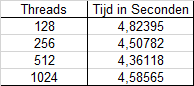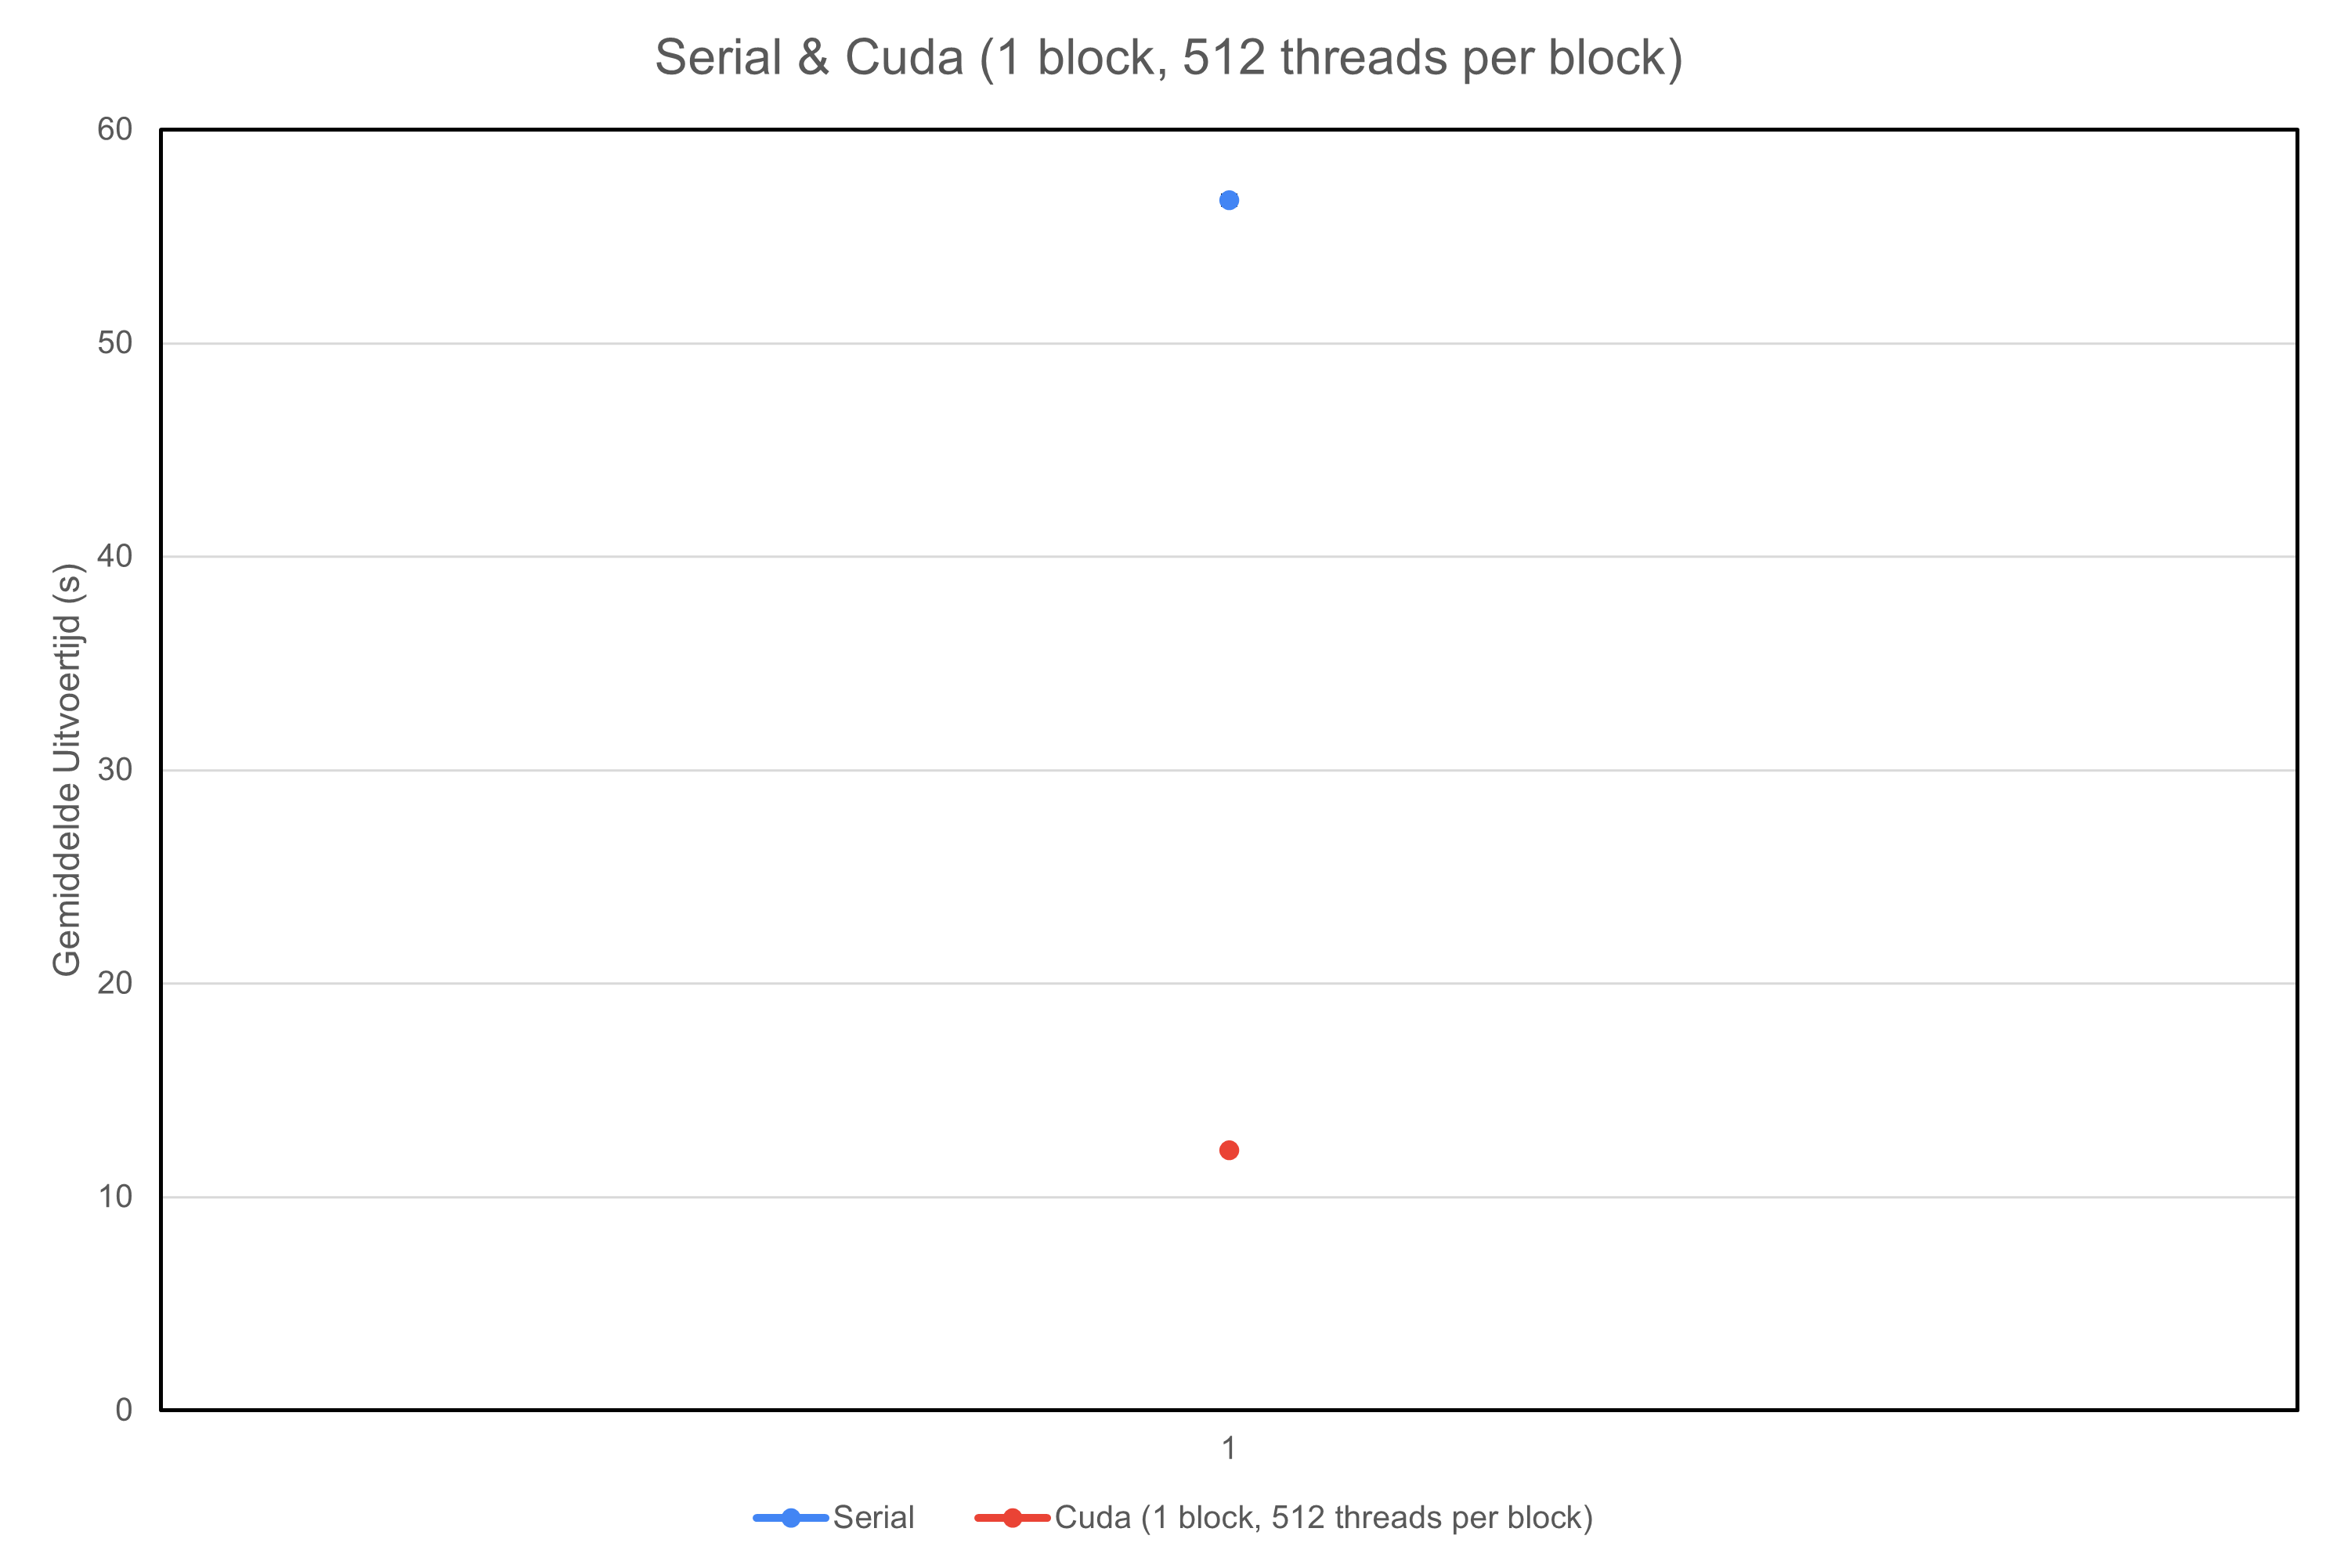)

*1. Schets je werkwijze, maw leg uit wat je geparallelliseerd hebt en waarom. Zijn er delen die je bewust niet geparallelliseerd hebt (en waarom niet)? Hoe past dit bij de keuze van je dataset en parameters (k, repetitions)?*

Zoals in OpenMp versie, hebben we ervoor gekozen om de meest tijdrovende delen van het kmeans algoritme te parallelliseren. Deze zijn het toewijzen van punten naar centroids en het updaten van centroids.


1. Toewijzen punt naar centroid: kan perfect geparalleliseerd worden omdat er voor elk punt onafhankelijke berekeningen gedaan moeten worden.
```
//
__global__ void findClosestCentroidKernel(const double *allData, const double *centroids,
                                          int *clusters, bool *changes, double *distanceSquaredSum,
                                          size_t numCols, size_t numRows, int numClusters)
//
```
Deze CUDA-kernel is verantwoordelijk voor het toewijzen van elk data punt aan het dichtbijzijnde centroid. Het parallelisme wordt bereikt door elk data punt aan een afzonderlijke thread toe te wijzen, en het werk wordt verdeeld over meerdere threads en blokken. Binnen deze kernel wordt shared memory gebruikt om centroids tijdelijk op te slaan voor efficiënte acces door threads in een block.


2.   Updaten van centroids: parallelisatie omdat ze onafhankelijk van elkaar worden geupdate.
```
//
__global__ void accumulateCentroidsAndCountPointsKernel(const double *allData,  
                                          double *newCentroids,
                                          int*clusterNumPoints,
                                          const int *clusters,
                                          size_t numCols,
                                          size_t numPoints,
                                          size_t numClusters)
//
```
Deze is verantwoordelijk voor het accumuleren van de waarden van data punten die zijn toegewezen aan elke centoid en het tellen van het aantal punten in elk cluster.
```
//
__global__ void normalizeCentroidsKernel(double *newCentroids,
                                          const int *clusterNumPoints,
                                          size_t numCols,
                                          size_t numClusters)
//
```
Deze kernel is verantwoordelijk voor het normaliseren van de geaccumuleerde centroids door ze te delen door het aantal punten in elke cluster.

Zoals vermeld in OpenMp, konden we ook andere delen paralleliseren zoals het inladen van de data maar aangezien de timer pas begint na het inladen en stopt voor het uitschrijven, heeft het kmeans algoritme enkel onze aandacht.

Het enige wat versnelt wordt is dus de berekeningen. Herhalingen zullen serieel gebeuren en dataset zal serieel ingelezen worden. Onze oplossing zal enkel invloed hebben om parameter k (process versnellen)


*2. Maak een vergelijking van je seriële uitvoertijd met die van je CUDA implementatie voor 1 block. Baseer dit op een aantal herhaalde metingen.*

Binnen dit grafiek kunt u de vergelijking van gemiddelde uitvoertijd zien tussen de seriele en de Cuda versie met 1 blocks en 512 threads per block over 10 herhalingen. We zien best wel een verschil in tijd, dit komt omdat we gebruik maken van 512 threads per block. Dit versnelt het proces nog altijd binnen 1 block.

De standaardafwijking is niet zichtbaar op grafiek omdat deze zeer klein zijn. Overzicht van data vind u hieronder:

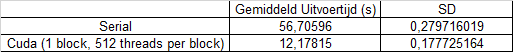

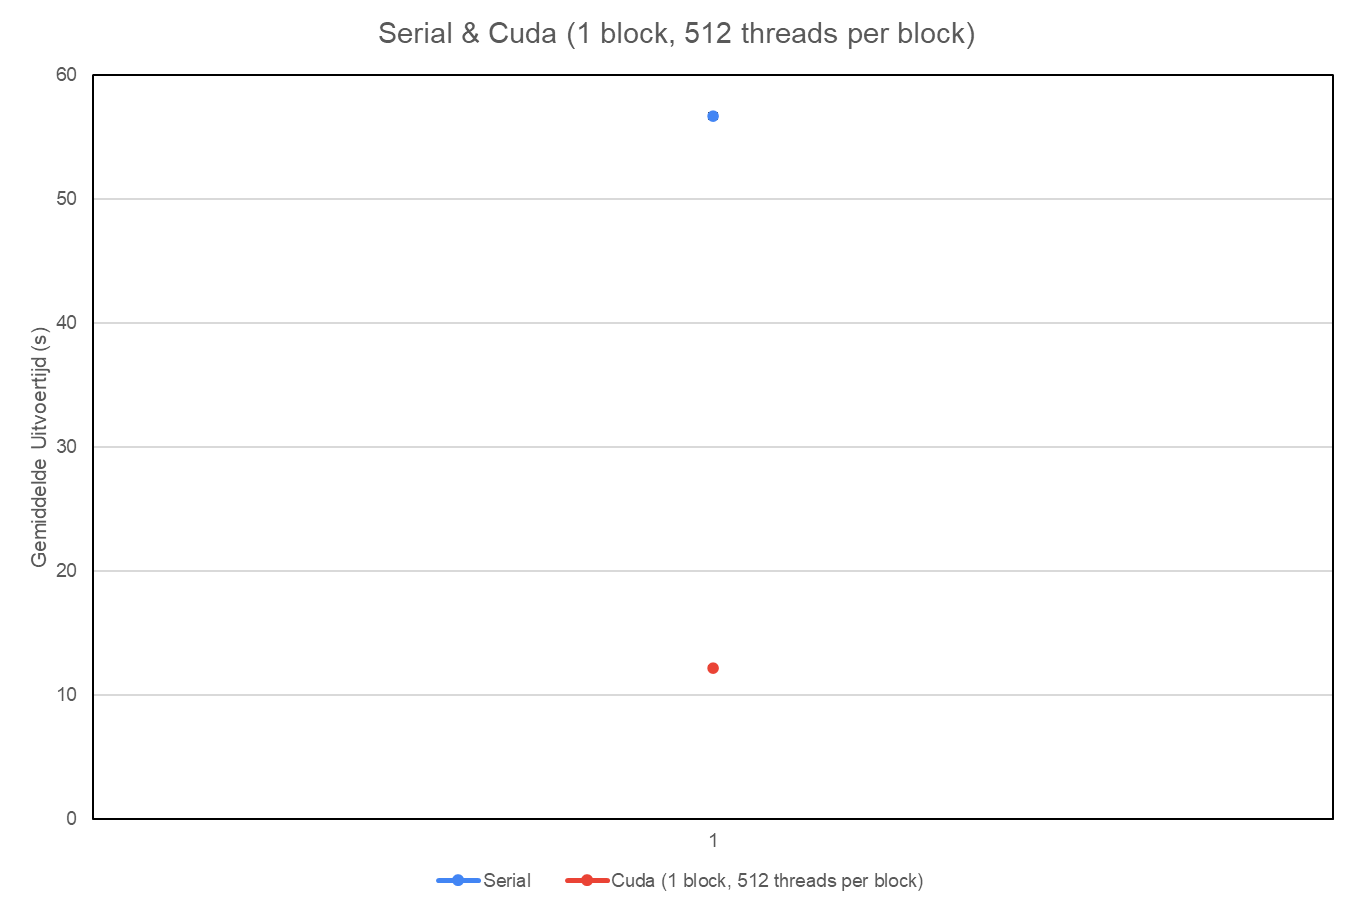

*3. Toon (figuren!) hoe de efficiëntie en speedup veranderen met het gebruikte aantal blocks.
Denk er weer aan dat je je metingen herhaalt zodat je bvb gemiddelde en standaardafwijking kan
tonen, en vermeld dit aantal. Gebruik de gemiddelde uitvoertijd van de 1-block Cuda versie als referentietijd. Bespreek de schaalbaarheid van je implementatie*

Volgende grafieken zijn opgebouwd uit 10 herhalingen.

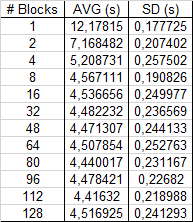

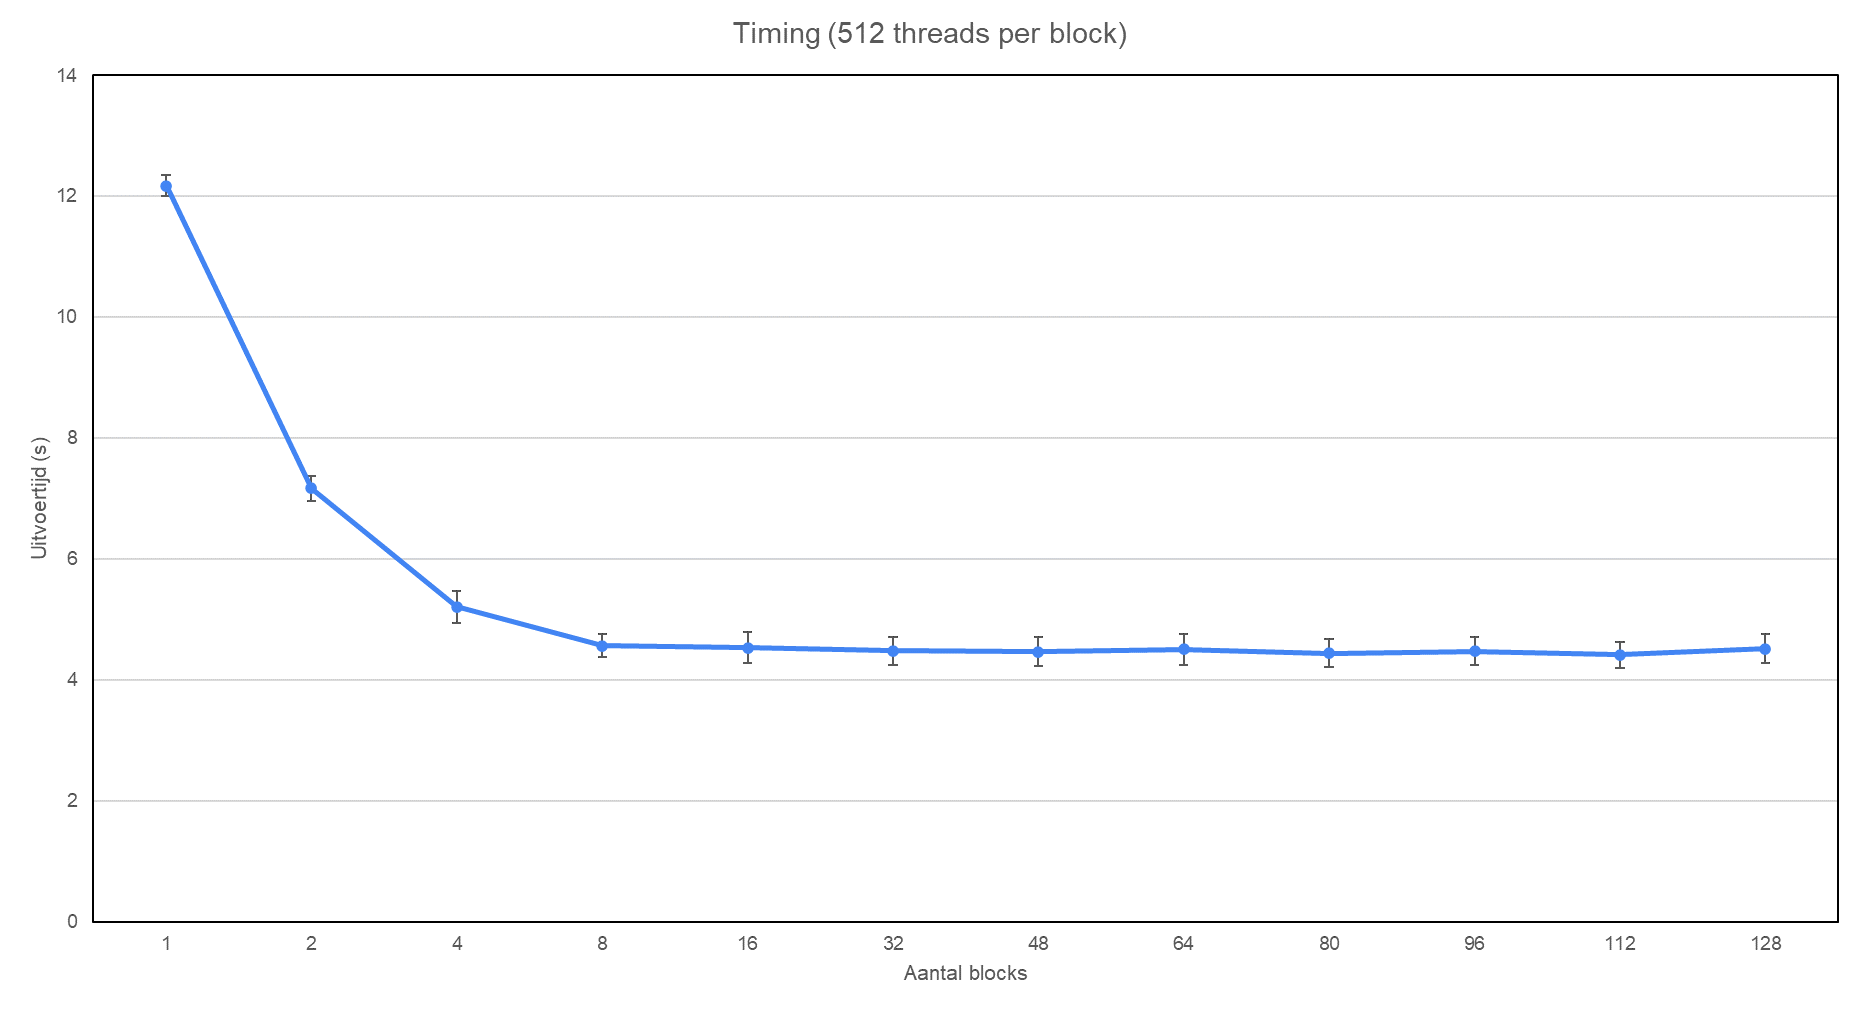

Speedup: standaardafwijking is weer klein:


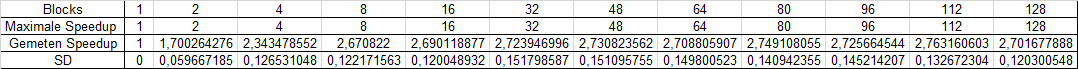

Grafiek 1 (box vorm, maar SD niet zichtbaar)

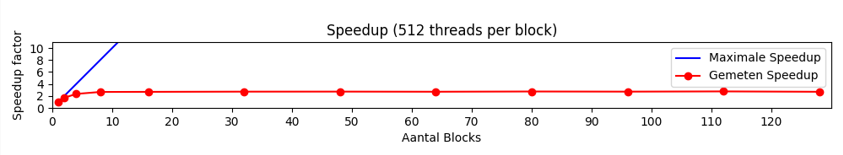

Grafiek 2 (geen box vorm, SD wel zichtbaar)

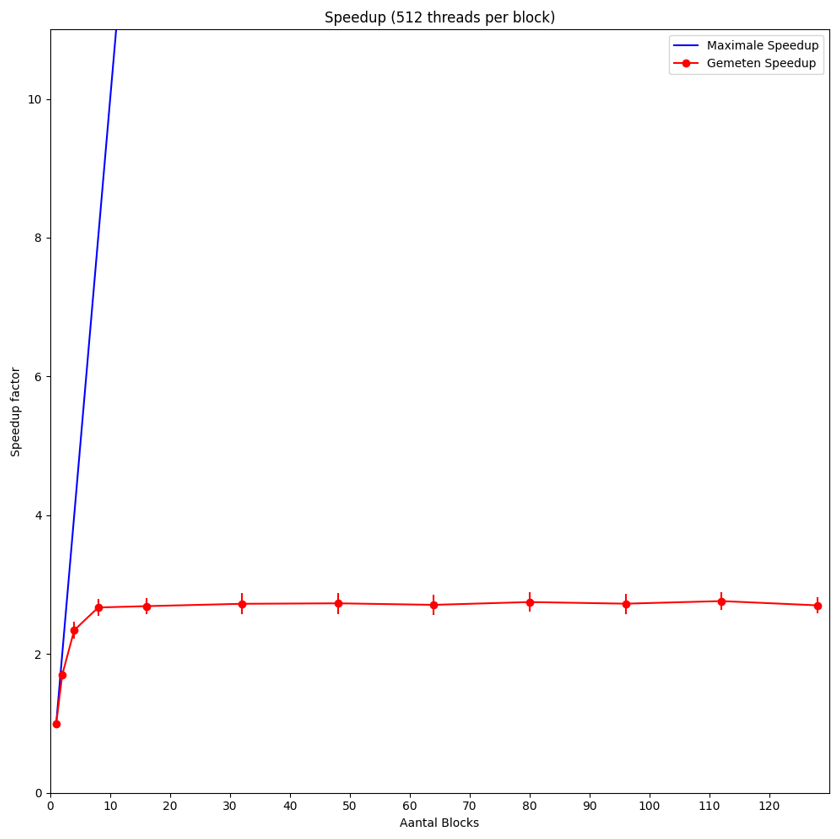

Efficiëntie:

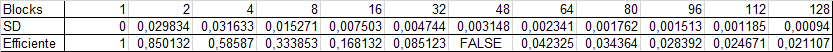

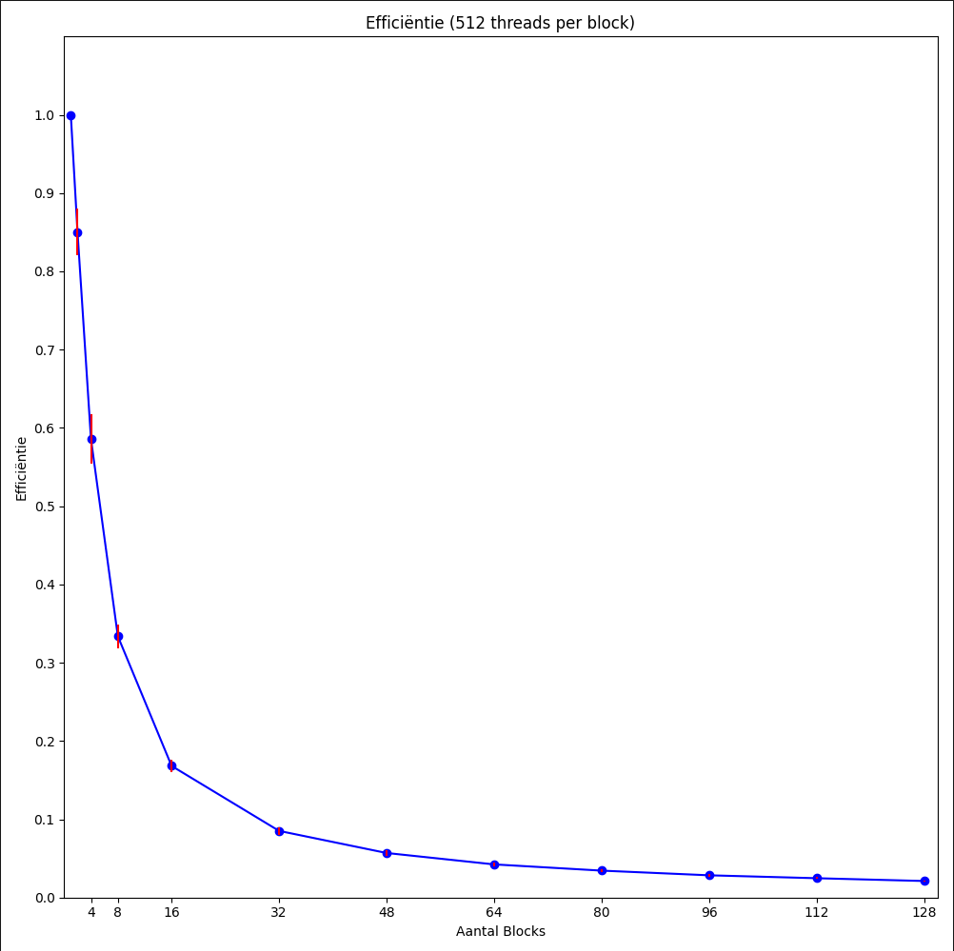

4. Deze metingen kan je gebruiken (zoals in de theorie) om de seriële fractie te schatten voor een bepaald aantal threads. Gebruik de metingen voor 8 blocks,en schat zo de seriële fractie (de gemiddelde tijden gebruiken volstaat, bvb standaardafwijking hoeft niet).

  Gemeten speedup met 8 blocks = 2,670822

  Formule voor speedup: $$Speedup = \frac{1}{s + \frac{1-s}{N}}$$
  Voor s : $$s = \frac{N - Speedup}{Speedup(N - 1)}$$
  
  $$s = \frac{8 - 2,670822}{2,670822(8 - 1)}$$
  
  $$s = 0,28504$$
  

  De seriële fractie van het programma is 28,504\%.



5. Op basis van deze seriële fractie kan je dan weer de uitvoertijd schatten voor 16 blocks. Doe dit, vergelijk met je gemeten uitvoertijd voor 16 blocks, en bespreek het verschil.

   Geschatte speedup voor 16 blocks: $$Speedup_{16} = \frac{1}{s + \frac{1-s}{N}}$$

   $$Speedup_{16} = \frac{1}{0,28504 + \frac{1-0,28504}{16}}$$

   $$Speedup_{16} = 3,03277$$

   Met de volgende formule kunnen we de executie tijd schatten:
   

  $$Speedup = \frac{T_{serieel}}{T_{parallel}}$$

  $$Speedup_{16} = \frac{T_{serieel}}{T_{parallel}}$$
  
  $$T_{parallel} = \frac{T_{serieel}}{Speedup_{16}}$$

  $$T_{parallel} = \frac{12,17815s}{3,03277}$$

  $$T_{parallel} = 4,0155261740365s$$


De geschatte uitvoertijd voor 16 blocks is 4.0155s en de gemeten uitvoertijd is 4,536656s.

6. Gebruik je metingen/berekeningen om je verwachtingen te beschrijven als je meer en meer SMs ter beschikking krijgt. Wat als dit oneindig veel zou zijn? Wat wordt de uitvoertijd in dat geval?

$$SM_{\infty} = \frac{1}{s}$$

$$SM_{\infty} = \frac{1}{0,28504}$$

$$SM_{\infty} = 3,5082$$

Als we dan de uitvoeringstijd berekenen aan de hand van de speedupfactor zoals hierboven komen we uit op 3,4713s

We kunnen nooit voorbij speedup factor van 3,5082 gaan en de uitvoeringstijd is gelimiteerd aan 3,4713s.



7. Welke manieren kan je bedenken om de schaalbaarheid nog te verbeteren (nog steeds met enkel CUDA)? Hoeveel werk zouden ze vergen?

We kunnen de schaalbaarheid verbeteren door de volgende aanpassingen:
- We maken gebruik van een 'changes' vector om te kijken of de centroids worden aangepast om na te gaan of het programma de juiste clustering heeft gevonden, dit zorgt voor veel overhead want we moeten de data meegeven naar de kernels waardoor we eigenlijk de data dubbel meegeven de originele vector en de changes vector.
-  NVIDIA Profiler tool gebruiken om bottlenecks te vinden en op te lossen
